In [68]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, make_scorer
import matplotlib.pyplot as plt
from scipy import interpolate
%matplotlib inline

## Read Data

In [39]:
X_train = pd.read_hdf('data/data_X_train')
X_test = pd.read_hdf('data/data_X_test')
y_train = pd.read_hdf('data/data_y_train')
y_test = pd.read_hdf('data/data_y_test')

## Grid search based on ROC curve

In [77]:
def score(fpr, tpr):
    f = interpolate.interp1d(fpr, tpr)
    score = 0.4 * f(0.001) + 0.3 * f(0.005) + 0.3 * f(0.01)
    return score

def ROC_GS(clf, X, y, params, n_splits = 6):
    
    def custom_score(ground_truth, predictions):
        fpr, tpr, _ = roc_curve(ground_truth, predictions[:, 1], pos_label=1)
        return score(fpr, tpr)

    my_auc = make_scorer(custom_score, greater_is_better=True, needs_proba=True)
    
    grid_cv = GridSearchCV(clf, param_grid = params, scoring = my_auc, cv = StratifiedKFold(n_splits=n_splits))
    grid_cv.fit(X, y)

    clf_best = grid_cv.best_estimator_
    score_best = grid_cv.best_score_
    param_best = grid_cv.best_params_

    return (clf_best, score_best, param_best)

In [73]:
## This is the test for roc score calculation
## It can be seen the result 0.0049 is not same as what is given by ATEC (which is 0.0055)
## Still need to be verified
test_case = pd.read_csv("data/baseline_May_5_2.csv")
test_truth = np.random.choice([0,1],test_case.shape[0])
fpr, tpr, _ = roc_curve(test_truth, test_case['score'], pos_label=1)
f = interpolate.interp1d(fpr, tpr)
score = 0.4 * f(0.001) + 0.3 * f(0.005) + 0.3 * f(0.01)
print(score)

0.0049


## Example

### Feature Extraction

In [40]:
def FeatureExtract(df_0):
    """A function convert datetime to numeric features, which includes:
        - sin_day_of_week
        - cos_day_of_week
        - weekday
       And also drop original datetime column and id column
    Args:
        df: a dataframe of all features
    output:
        df: a datafame with extracted various datetime features
    """
    df = df_0.copy()
    df['sin_day_of_week'] = df['date'].dt.weekday.apply(lambda x: np.sin(2*np.pi*x/7))
    df['cos_day_of_week'] = df['date'].dt.weekday.apply(lambda x: np.cos(2*np.pi*x/7))
    df['weekday'] = df['date'].dt.weekday.apply(lambda x: 0 if (x == 6 or x == 5) else 1)
    
    df = df.drop(['date'], axis=1)
    df = df.drop(['id'], axis=1)
    
    return df

In [41]:
X_train = FeatureExtract(X_train)
X_test = FeatureExtract(X_test)

In [42]:
display(X_train.head())
display(X_test.head())

,f1,f2,f3,f4,f6,f7,f8,f9,f10,f11,...,f13,f14,f15,f16,f17,f18,f19,sin_day_of_week,cos_day_of_week,weekday
0,0,1,1,0,0,1,1,1,1,2,...,2,1,1,0,0,1,0,0.781831,0.62349,1
1,1,0,1,0,1,1,1,2,1,0,...,0,1,1,1,1,0,1,0.781831,0.62349,1
2,1,0,1,0,0,7,2,1,2,0,...,1,1,0,0,1,0,1,0.781831,0.62349,1
3,0,1,1,0,0,6,1,1,0,2,...,1,0,1,1,1,0,0,0.781831,0.62349,1
4,0,1,0,0,1,4,1,1,1,1,...,0,1,0,0,1,1,1,0.781831,0.62349,1


,f1,f2,f3,f4,f6,f7,f8,f9,f10,f11,...,f13,f14,f15,f16,f17,f18,f19,sin_day_of_week,cos_day_of_week,weekday
0,1,1,1,1,0,7,2,1,1,1,...,1,2,1,1,2,1,0,0.974928,-0.222521,1
1,0,1,0,0,0,4,1,0,0,1,...,2,2,1,0,1,2,0,0.974928,-0.222521,1
2,1,1,0,1,1,6,2,1,1,1,...,2,1,2,2,1,2,2,0.974928,-0.222521,1
3,1,1,1,0,0,4,2,1,2,0,...,0,2,1,2,2,2,1,0.974928,-0.222521,1
4,0,0,1,0,1,7,2,1,2,1,...,1,2,1,1,2,2,1,0.974928,-0.222521,1


### Model selection

Here is an example for Random Forest

best parameters:  {'max_depth': 2, 'n_estimators': 25}
test score for cross-validation:  0.144047366967
test score for default parameters setting:  0.155456727895


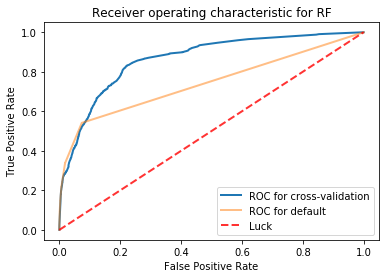

In [79]:
clf = RandomForestClassifier(random_state=0)
params = {'n_estimators': np.arange(5,30,5), 'max_depth': np.arange(1,3,1) }

(best_clf, score_best, best_param) = ROC_GS(clf, X_train.values, y_train.values.ravel(), params, n_splits = 25)
print("best parameters: ", best_param)

fpr_best, tpr_best, thresholds_best = roc_curve(y_test, best_clf.predict_proba(X_test.values)[:,1])

plt.plot(fpr_best, tpr_best, lw=2,
                     label='ROC for cross-validation')
print("test score for cross-validation: ", score(fpr_best, tpr_best))

default_clf = RandomForestClassifier(random_state=0)
default_clf.fit(X_train.values, y_train.values.ravel())
fpr_default, tpr_default, thresholds_default = roc_curve(y_test, default_clf.predict_proba(X_test.values)[:,1])
roc_auc_default = auc(fpr_default, tpr_default)
plt.plot(fpr_default, tpr_default, lw=2, alpha=0.5,
                     label='ROC for default')
print("test score for default parameters setting: ", score(fpr_default, tpr_default))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for RF')
plt.legend(loc="lower right")
plt.show()

### Prediction

In [113]:
X_test_ = pd.read_hdf('data/data_test_')

result = X_test_['id']

X_test_ = FeatureExtract(X_test_)
score_test_ = pd.DataFrame(best_clf.predict_proba(X_test_)[:,1], columns = ['score'])

result = pd.concat([result, score_test_], axis=1)
result.head()

,id,score
0,8e8290c270ec4bc3448dd5edd35c6f059b42d38f9ddd6f...,0.006872
1,f36c5fa5c0e7afccf733a4d74c7e06ffe43cc8fd24eda7...,0.019591
2,ee85f808b1fd49eaba308527e1686c509dc8e3e5057488...,0.006872
3,0df905aa187938d56a9b0816b13f54ac1f87d658a33cd0...,0.007531
4,15f532f979c4f092bbbe28e5409c8c3b8454ece8f1ab3e...,0.017981


In [114]:
result.to_csv('data/example.csv', index=False)